In [25]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

import timm
import torch
import detectors
from utils import cka as CKA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os
from tqdm import tqdm

from data_utils.data_stats import *
from models.networks import get_model
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset

In [32]:
# define important parameters

dataset         = 'cifar10'               # One of cifar10, cifar100, stl10, imagenet or imagenet21
num_classes     = CLASS_DICT[dataset]
data_path       = '/scratch/data/ffcv'
model_path      = '/scratch/zooming_in_on_mlps/vit_models'
eval_batch_size = 32
data_resolution = 32 
checkpoint      = None

cka_internal    = True 

#model1_type     = 'mlp'                   
#checkpoint      = 'in21k_cifar10'       
#architecture    = 'B_12-Wi_1024'        
#crop_resolution = 64            

#model1_type     = 'cnn'               
#architecture    = 'resnet18_' + dataset                      
#crop_resolution = 32

model1_type     = 'vit'                  
architecture    = 'vit_small_patch16_224_' + dataset + '_7.pth'        
crop_resolution = 224          


# model 2
#model2_type      = 'cnn'
#architecture2    = 'resnet18_' + dataset
#crop_resolution2 = 32

model2_type      = 'vit'
crop_resolution2 = 224
architecture2    = 'vit_small_patch16_224_' + dataset + '_v7.pth'

In [33]:
def get_models_full(model_type, 
                    architecture, 
                    resolution  = crop_resolution, 
                    num_classes = CLASS_DICT[dataset], 
                    checkpoint  = checkpoint, 
                    model_path   = model_path):
    if model_type == 'mlp':
        model = get_model(architecture=architecture, resolution = resolution, 
                          num_classes=num_classes,checkpoint= checkpoint)
    elif model_type == 'cnn':
        model = timm.create_model(architecture, pretrained=True)
    elif model_type == 'vit':
        model = torch.load(os.path.join(model_path, architecture))
    return model

In [34]:
# load the models
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model1 = get_models_full(model1_type, architecture)
if cka_internal == False:
    model2 = get_models_full(model2_type, architecture2)
    

In [35]:
# Get the custom test loader need to take care of different image sizes. Now fixed only for mlp with 64x64
if cka_internal == True:
    loader = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )
else:
    loader1 = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution,
    )
    loader2 = get_loader(
        dataset,
        bs=eval_batch_size,
        mode="test",
        augment=False,
        dev=device,
        mixup=0.0,
        data_path=data_path,
        data_resolution=data_resolution,
        crop_resolution=crop_resolution2,
    )

Loading /scratch/data/ffcv/cifar10/val_32.beton


In [37]:
@torch.no_grad()
def compute_cka_internal(model, loader, cka, model_type):

    model.eval()
    #register hooks
    activations = {} 
    CKA.register_hooks(model, activations, model_type)
    i = 0 
    for ims, targs in tqdm(loader, desc="Evaluation"):
        if model_type == 'mlp': ims   = torch.reshape(ims, (ims.shape[0], -1))
        CKA.process_batch(model, ims, cka, activations)
        i += 1
    return cka.result()

In [38]:
@torch.no_grad()
def compute_cka_across(model1, model2, loader, loader2, cka, model1_type, model2_type):

    model1.eval()
    model2.eval()
    #register hooks
    activations1 = {}
    activations2 = {} 
    CKA.register_hooks(model1, activations1, model1_type)
    CKA.register_hooks(model2, activations2, model2_type)

    k = 0
    for i, (ims, targs) in enumerate(tqdm(loader, desc="Evaluation")):
        for j, (ims2, targs2) in enumerate(loader2):
            
            if i != j:  continue
            assert torch.equal(targs,targs2), f'Mismatch in batches {i}, {j}'
            print(targs)
            if model1_type == 'mlp': 
                ims   = torch.reshape(ims, (ims.shape[0], -1))
            if model2_type == 'mlp':
                ims2 = torch.reshape(ims2, (ims2.shape[0], -1))
            
            acts1 = CKA.get_activations(ims, model1, activations1)
            acts2 = CKA.get_activations(ims2, model2, activations2)
            cka.update_state_across_models(acts1, acts2)
            break 
    return cka.result()

The parameter cka_internal has value True


Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Evaluation:  19%|█▉        | 60/313 [06:39<28:04,  6.66s/it]


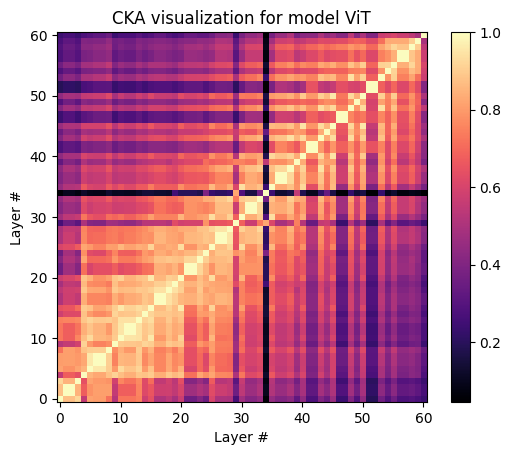

In [39]:
import matplotlib.pyplot as plt

print("The parameter cka_internal has value", cka_internal)
if cka_internal:
    _, n_layers = CKA.find_layers(model1, model1_type)
    cka         = CKA.MinibatchCKA(n_layers, None, across_models=False)
    heatmap     = compute_cka_internal(model1, loader, cka, model1_type) 
else:
    _, n_layers1 = CKA.find_layers(model1, model1_type)
    _, n_layers2 = CKA.find_layers(model2, model2_type)

    cka          = CKA.MinibatchCKA(n_layers1, n_layers2, across_models=True)
    heatmap      = compute_cka_across(model1, model2, loader1, loader2, cka, model1_type, model2_type)

heatmap = heatmap.numpy()
plt.imshow(heatmap, cmap = 'magma', origin = 'lower')
plt.xlabel('Layer #')
plt.ylabel('Layer #')
if cka_internal:
    if model1_type == 'mlp':
        tit = 'MLP'
    if model1_type == 'cnn':
        tit = 'CNN'
    if model1_type == 'vit':
        tit = 'ViT'
    plt.title(f'CKA visualization for model {tit}')
else:
    plt.title(f'CKA across model {model1_type} and {model2_type}')
plt.colorbar()
plt.show()